# MNIST Klassifikation mit CNNs

In dieser Übung steht der MNIST Datensatz im Mittelpunkt. Dieser Datensatz enhält eine Klassifikationsaufgabe mit Bildern handschriftlicher Ziffern. Zunächst wird ein einfacher Klassifikator auf dem Datensatz trainiert und evaluiert. Im weiteren Verlauf wird dann ein einfaches CNN zur Klassifikation verwendet.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Der MNIST Datensatz

In [3]:
# MNIST dataset can be automatically downloaded from within TensorFlow
import tensorflow.keras.datasets.mnist as keras_mnist
(x_train, y_train), (x_test, y_test) = keras_mnist.load_data()

# In this source, there is no separated validation data, so we have to split the training set
x_train, x_val = np.split(x_train, [50000])
y_train, y_val = np.split(y_train, [50000])

In [4]:
print("Train Set Shape: " + str(x_train.shape))
print("Validation Set Shape: " + str(x_val.shape))
print("Test Set Shape: " + str(x_test.shape))

Train Set Shape: (50000, 28, 28)
Validation Set Shape: (10000, 28, 28)
Test Set Shape: (10000, 28, 28)


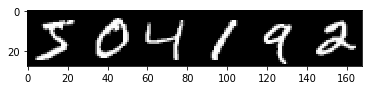

In [5]:
plt.imshow(np.concatenate((x_train[:6]), axis=1))
plt.gray()
plt.show()

In [6]:
print("First 6 training labels: \n" + str(y_train[:6]))

First 6 training labels: 
[5 0 4 1 9 2]


In [7]:
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print("First 6 training lables as one-hot encoded vectors:\n", str(y_train[:6]))
print("Each line represents one label.")

First 6 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Each line represents one label.


In [8]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [9]:
keras_mnist_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
keras_mnist_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
keras_mnist_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

## Solving MNIST - ein erstes einfaches NN

Der letzte Abschnitt diente im Wesentlichen zur Visualisierung der einzelnen Schritte, die beim Laden der Trainingsdaten durchgeführt werden. Nachfolgend wird der MNIST Datensatz aus tensorflow_datasets verwendet. Dort wurden die gezeigten Schritte bereits beim Laden durchgeführt. Ein Vorteil ist dabi auch, dass der Datensatz direkt als dataset Objekt vorliegt. Es ist zwar grundsätzlich nicht notwendig, dass ein Dataset Objekt aus den Daten erzeugt wird - die Daten könnnen auch in Form eines numpy-Arrays an das Model übergeben werden - allerdings ist das Arbeiten mit einem Dataset deutlich komfortabler.

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Für die in tensorflow_datasets verfügbaren Datensätze werden auch Metadaten mitgeliefert, die einige Informationen zu den Datensätzen enthalten. Diese können z. B. beim Laden gleich mit abgefragt werden.

In [11]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

Da eine Normalisierung der Daten nicht für jedes Modell zwingend ist, und sowohl der Datentyp als auch das Verfahren nicht einheitlich sein müssen, kann dmieser Schritt nicht bereits durch tensorflow_datasets durchgeführt werden. Zu diesem Zweck wird eine Transformationsfunktion bestimmt, die jedes Datum im Datensatz durchlaufen muss. 

In [12]:
def normalize_img(image, label):
  # Normalizes images: uint8 -> float32, [0,255] -> [0,1]
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Danach werden Eigenschaften des Datensatzes wie die Batch-Size oder die Menge der im Voraus zu ladenden Daten festgelegt. Hier kann auch schon die Anzahl der Trainingsepochen festegelegt werden. In diesem Beispiel wird diese erst innerhalb der Trainingsfunktion festgelegt. 

In [13]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Mittels der Sequential API von Keras wird danach ein einfaches Model definiert, das MNIST erfolgreich klassifizieren soll. Die Sequential API von Keras bietet die schnellste Möglichkeit, einfache Netze mit nur einer Ein- und einer Ausgabe zu definieren.

In [15]:
model_seq = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

Ist das Model definiert, kann es anschließend kompiliert werden. Hierbei kann dem Model auch eine Loss-Funktion und ein Optimizer zugewiesen werden. Zusätzlich können Metriken definiert werden, die beim Training des Netzes berechnet werden.

In [16]:
model_seq.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

Im Anschluss kann das Model dann trainiert werden. Da die Daten als Dataset vorliegen, können sie direkt als ganzes übergeben werden. Andernfalls müssten an der Stelle Bilder und Label in getrennten numpy-Arrays übergeben werden. Zusätzlich wird an dieser Stelle auch die Anzahl der Epochen festgelegt, die das Model trainiert werden soll. Als Validationsdatensatz wird an dieser Stelle AUSNAHMSWEISE der Testdatensatz verwendet, um die Güte der einzelnen Modelle zu visualisieren. Eine Auswahl der Modelle anhand dieser Daten wäre nicht zulässig!

In [17]:
history = model_seq.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3566 - accuracy: 0.9013 - val_loss: 0.1967 - val_accuracy: 0.9439
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1684 - accuracy: 0.9523 - val_loss: 0.1353 - val_accuracy: 0.9620
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1214 - accuracy: 0.9649 - val_loss: 0.1109 - val_accuracy: 0.9691
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0942 - accuracy: 0.9730 - val_loss: 0.0942 - val_accuracy: 0.9713
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0764 - accuracy: 0.9781 - val_loss: 0.0849 - val_accuracy: 0.9752
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0641 - accuracy: 0.9814 - val_loss: 0.0782 - val_accuracy: 0.9766
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0533 - accuracy: 0.9847 - val_loss: 0.0748 - val_accuracy: 0.9788
Epoch 

## MNIST mit CNNs

Mit 97% Accuracy war das einfache Neuronale Netz schon recht gut. Die Vermutung liegt allerdings nahe, dass ein CNN hier noch deutlich bessere Werte erreichen kann. Deshalb wird nachfolgend ein einfaches CNN mit 2 Conv und 2 Pooling Schichten definiert. Das Model wird ebenfalls mit der Sequential API von Keras definiert. Zu Demonstrationszwecken wird für dieses Model allerdings zunächst ein leeres Model erstellt und die einzelnen Layer erst nach und nach hinzugefügt. Auch hierbei muss dem ersten Layer durch den input_shape Parameter mitgeteilt werden, welche Form die Eingabedaten haben werden.

In [23]:
model_seq_cnn = tf.keras.Sequential(name="Sequential_CNN")
model_seq_cnn.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model_seq_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_seq_cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_seq_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_seq_cnn.add(tf.keras.layers.Dropout(0.25))
model_seq_cnn.add(tf.keras.layers.Flatten())
model_seq_cnn.add(tf.keras.layers.Dense(128, activation='relu'))
model_seq_cnn.add(tf.keras.layers.Dropout(0.5))
model_seq_cnn.add(tf.keras.layers.Dense(10, activation='softmax'))

In [24]:
model_seq_cnn.summary()

Model: "Sequential_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)            

In [25]:
model_seq_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [26]:
history = model_seq_cnn.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 7s 14ms/step - loss: 0.3144 - accuracy: 0.9024 - val_loss: 0.0595 - val_accuracy: 0.9808
Epoch 2/6
469/469 [==============================] - 7s 14ms/step - loss: 0.1059 - accuracy: 0.9679 - val_loss: 0.0374 - val_accuracy: 0.9876
Epoch 3/6
469/469 [==============================] - 7s 15ms/step - loss: 0.0795 - accuracy: 0.9763 - val_loss: 0.0372 - val_accuracy: 0.9884
Epoch 4/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0664 - accuracy: 0.9801 - val_loss: 0.0291 - val_accuracy: 0.9894
Epoch 5/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0575 - accuracy: 0.9828 - val_loss: 0.0287 - val_accuracy: 0.9910
Epoch 6/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0521 - accuracy: 0.9838 - val_loss: 0.0267 - val_accuracy: 0.9908


## Die Functional API

Mit der Functional API von Keras können auch Netze definiert werden, die deutlich komplexer sind als einfache sequentielle Netze. So können z. B. Netze mit mehreren Eingaben oder mehreren Ausgaben erstellt werden. Es können natürlich auch einfache Netze wie die bisher gesehenen definiert werden:

In [27]:
img_input = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(img_input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)
model_func = tf.keras.Model(img_input, x, name="Functional_Model")

In [28]:
model_func.summary()

Model: "Functional_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)         

In [30]:
model_func.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [31]:
history = model_func.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 7s 14ms/step - loss: 0.3095 - accuracy: 0.9038 - val_loss: 0.0623 - val_accuracy: 0.9798
Epoch 2/6
469/469 [==============================] - 7s 14ms/step - loss: 0.1065 - accuracy: 0.9682 - val_loss: 0.0412 - val_accuracy: 0.9860
Epoch 3/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0781 - accuracy: 0.9760 - val_loss: 0.0339 - val_accuracy: 0.9888
Epoch 4/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0661 - accuracy: 0.9805 - val_loss: 0.0273 - val_accuracy: 0.9897
Epoch 5/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0550 - accuracy: 0.9837 - val_loss: 0.0287 - val_accuracy: 0.9895
Epoch 6/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0501 - accuracy: 0.9856 - val_loss: 0.0274 - val_accuracy: 0.9906


In [33]:
img_input = tf.keras.Input(shape=(960, 1280, 3))

# Block 1
x = tf.keras.layers.Conv2D(64, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block1_conv1')(img_input)
x = tf.keras.layers.Conv2D(64, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block1_conv2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = tf.keras.layers.Conv2D(128, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block2_conv1')(x)
x = tf.keras.layers.Conv2D(128, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block2_conv2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = tf.keras.layers.Conv2D(256, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block3_conv1')(x)
x = tf.keras.layers.Conv2D(256, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block3_conv2')(x)
x = tf.keras.layers.Conv2D(256, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block3_conv3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = tf.keras.layers.Conv2D(512, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block4_conv1')(x)
x = tf.keras.layers.Conv2D(512, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block4_conv2')(x)
x = tf.keras.layers.Conv2D(512, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block4_conv3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = tf.keras.layers.Conv2D(512, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block5_conv1')(x)
x = tf.keras.layers.Conv2D(512, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block5_conv2')(x)
x = tf.keras.layers.Conv2D(512, (3, 3),
                          activation='relu',
                          padding='same',
                          name='block5_conv3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = tf.keras.layers.Conv2D(4096, 7, name="HDTLR/conv_1", padding="same", activation='relu')(x)
x = tf.keras.layers.Dropout(0.5, name="HDTLR/drop_conv_1")(x)
x = tf.keras.layers.Conv2D(4096, 1, name="HDTLR/conv_2", padding="same", activation='relu')(x)
split = tf.keras.layers.Dropout(0.5, name="HDTLR/drop_conv_2")(x)

classification = tf.keras.layers.Conv2D(832, 1, name="HDTLR/conv_class", activation='relu')(split)
bb = tf.keras.layers.Conv2D(256, 1, name="HDTLR/conv_bb", padding="same", activation='relu')(split)

model_det = tf.keras.Model(img_input, [classification, bb], name='detection_mod')

In [34]:
model_det.summary()

Model: "detection_mod"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 960, 1280, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 960, 1280, 64 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 960, 1280, 64 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 480, 640, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________

## Definition eigener Layer

Keras bietet bereits eine Vielzahl vordefinierter Layer. Sollten über diese Layer hinaus weitere Layer benötigt werden, ist es in TensorFlow natürlich nach wie vor möglich, eigene Layer zu definieren. Hier wurde beispielhaft eine vereinfachte Version des Conv2D Layers erstellt.

In [35]:
from tensorflow.python.ops import nn_ops

class My_Conv2D(tf.keras.layers.Layer):
    def __init__(self,
                 filters,
                 kernel_size,
                 padding='valid',
                 activation=None,
                 data_format=None,
                 trainable=True,
                 name=None,
                 **kwargs):
        super(My_Conv2D, self).__init__(
            trainable=trainable,
            name=name,
            activity_regularizer=tf.python.keras.regularizers.get(None),
            **kwargs)
        self.filters = filters
        self.activation = tf.python.keras.activations.get(activation)
        self.kernel_size = tf.python.keras.utils.conv_utils.normalize_tuple(
            kernel_size, 2, 'kernel_size')
        self.dilation_rate = tf.python.keras.utils.conv_utils.normalize_tuple(
            1, 2, 'dilation_rate')
        self.strides = tf.python.keras.utils.conv_utils.normalize_tuple(1, 2, 'strides')
        self.padding = tf.python.keras.utils.conv_utils.normalize_padding(padding)
        self.data_format = tf.python.keras.utils.conv_utils.normalize_data_format(None)
        self.kernel_initializer = tf.python.keras.initializers.get('glorot_uniform')
        self.kernel_regularizer = tf.python.keras.regularizers.get(None)
        self.kernel_constraint = tf.python.keras.constraints.get(None)
    
    def build(self, input_shape):
        input_shape = tf.python.framework.tensor_shape.TensorShape(input_shape)
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(
            name='kernel',
            shape=kernel_shape,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)
        self.bias = None
        
        if self.padding == 'causal':
            op_padding = 'valid'
        else:
            op_padding = self.padding
        if not isinstance(op_padding, (list, tuple)):
            op_padding = op_padding.upper()

        
        self._convolution_op = nn_ops.Convolution(
            input_shape,
            filter_shape=self.kernel.shape,
            dilation_rate=self.dilation_rate,
            strides=self.strides,
            padding=op_padding,
            data_format=tf.python.keras.utils.conv_utils.convert_data_format(self.data_format,
                                                       2 + 2))
        self.built = True

    def call(self, inputs):
        outputs = self._convolution_op(inputs, self.kernel)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

Anschließend kann dieser Layer analog zu den in Keras definierten Layern für den Aufbau des Models verwendet werden.

In [36]:
img_input = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(img_input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = My_Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)
model_func_layer = tf.keras.Model(img_input, x, name="Functional_Model")

In [37]:
model_func_layer.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [38]:
history = model_func_layer.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 7s 14ms/step - loss: 0.2997 - accuracy: 0.9082 - val_loss: 0.0627 - val_accuracy: 0.9815
Epoch 2/6
469/469 [==============================] - 7s 14ms/step - loss: 0.1064 - accuracy: 0.9690 - val_loss: 0.0424 - val_accuracy: 0.9852
Epoch 3/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0801 - accuracy: 0.9763 - val_loss: 0.0398 - val_accuracy: 0.9864
Epoch 4/6
469/469 [==============================] - 7s 15ms/step - loss: 0.0654 - accuracy: 0.9801 - val_loss: 0.0330 - val_accuracy: 0.9888
Epoch 5/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0577 - accuracy: 0.9827 - val_loss: 0.0276 - val_accuracy: 0.9909
Epoch 6/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0498 - accuracy: 0.9848 - val_loss: 0.0286 - val_accuracy: 0.9908


## Definition eines eigenen Models

Sobald man an die Grenzen der Functional API stößt, hat man noch die Möglichkeit, ein eigenes Model als Subklasse der Keras Klasse Model zu erstellen. Hiermit ist es dann möglich, einzelne Methoden der Klasse zu überschreiben und so an beliebiger Stelle ein selbst gewähltes Verhalten zu definieren. Im nachfolgenden Beispiel wird zunächst im Kostruktor das Model erstellt. Zusätzlich wird die train_step Methode überschrieben, um das Verhalten in den einzelnen Schritten selbst definieren zu können.

In [39]:
class My_Model(tf.keras.Model):

    def __init__(self, name="My_Model", **kwargs):
        img_input = tf.keras.Input(shape=(28, 28, 1))
        x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(img_input)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(10, activation='softmax')(x)
        model = tf.keras.Model(img_input, x)
        super(My_Model, self).__init__(inputs=model.inputs, outputs=model.outputs, name=name, **kwargs)

    def train_step(self, data):
        x, y = data

        # watch gradients
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

Mit der erstellten Klasse kann nun ein Model generiert werden. Mit Aufruf der Summary zeigt sich, dass auch aus dieser Methode die selbe Architektur resultiert.

In [40]:
my_model = My_Model()
my_model.summary()

Model: "My_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0  

In [42]:
my_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [43]:
history = my_model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test
)

Epoch 1/6
469/469 [==============================] - 6s 14ms/step - loss: 0.3039 - accuracy: 0.9065 - val_loss: 0.0587 - val_accuracy: 0.9807
Epoch 2/6
469/469 [==============================] - 7s 14ms/step - loss: 0.1030 - accuracy: 0.9695 - val_loss: 0.0390 - val_accuracy: 0.9865
Epoch 3/6
469/469 [==============================] - 6s 14ms/step - loss: 0.0764 - accuracy: 0.9771 - val_loss: 0.0325 - val_accuracy: 0.9882
Epoch 4/6
469/469 [==============================] - 6s 14ms/step - loss: 0.0639 - accuracy: 0.9811 - val_loss: 0.0295 - val_accuracy: 0.9897
Epoch 5/6
469/469 [==============================] - 7s 14ms/step - loss: 0.0560 - accuracy: 0.9828 - val_loss: 0.0292 - val_accuracy: 0.9894
Epoch 6/6
469/469 [==============================] - 6s 14ms/step - loss: 0.0507 - accuracy: 0.9843 - val_loss: 0.0262 - val_accuracy: 0.9908
